# Example of single-cell multi-omics data (primary mouse fibroblasts)

In this tutorial, we use primary mouse fibroblasts as an example to show the basic application of BurstLink to single-cell multi-omics data [[Larsson et al., 2019](https://www.nature.com/articles/s41586-018-0836-1), [Kamimoto et al., 2023](https://www.nature.com/articles/s41586-022-05688-9)].

In [1]:
# Importing packages
import os
import numpy as np
import pandas as pd
from IPython.display import Image, display
# import celloracle as co
import burstlink as bl

In [ ]:
# Setting your work dictionary
os.chdir("your_path/realistic_data")

## Data preprocessing

### Preprocessing for scRNA-seq data

First, we perform basic preprocessing of scRNA-seq data, including filtering out, and data visualization [[Larsson et al., 2019](https://www.nature.com/articles/s41586-018-0836-1)].

You can download the processed data that were aligned and annotated in this link https://morris-lab.github.io/CellOracle.documentation/index.html:

In [ ]:
read_filename1 = os.path.abspath('primary_mouse_data/raw_data/SS3_c57_UMIs_concat.csv')
read_filename2 = os.path.abspath('primary_mouse_data/raw_data/SS3_cast_UMIs_concat.csv')
save_filename1 = 'countsdata_matrix.csv'
save_filename2 = 'stat_matrix.csv'
counts_matrix, stat_matrix = bl.pp._preprocessing.RNAseq_analysis(read_filename1, read_filename2, save_filename1, save_filename2, verbose = True)

### Preprocessing for scATAC-seq data

Next, we perform basic preprocessing of base GRN constructed from scATAC-seq data to narrow the scope of possible regulatory candidate genes in scRNA-seq data, including gene-pair interactions selection, filtered GRNs integration, and scRNA-seq data screening [[Kamimoto et al., 2023](https://www.nature.com/articles/s41586-022-05688-9)].

You can download the processed data that were aligned and annotated in this link https://morris-lab.github.io/CellOracle.documentation/index.html:

In [ ]:
base_GRN_scATAC = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN_promoter = co.data.load_mouse_promoter_base_GRN()
df1 = pd.DataFrame(base_GRN_scATAC)
df1.to_csv("primary_mouse_data/raw_data/base_GRN_scATAC.csv")
df2 = pd.DataFrame(base_GRN_promoter)
df2.to_csv("primary_mouse_data/raw_data/base_GRN_promoter.csv")

:::{note}
The `celloracle` package is only for downloading the data documents. If you have problems downloading, you can directly use our downloaded file in the folder `/primary_mouse_fibroblasts/raw_data`.
:::

Extract bi-direction information for gene-pair interactions from base-GRNs constructed by scATAC-seq data and motif scanning respectively.

In [ ]:
read_filename1 = os.path.abspath('primary_mouse_data/raw_data/mm9_mouse_atac_atlas_data_TSS_and_cicero_0.9_accum_threshold_10.5_DF_peaks_by_TFs_v202204.parquet')
read_filename2 = os.path.abspath('primary_mouse_data/raw_data/mm10_TFinfo_dataframe_gimmemotifsv5_fpr2_threshold_10_20210630.parquet')
save_filename1 = 'genepair_grn_atac.csv'
save_filename2 = 'genepair_grn_tf.csv'
grn_atac = bl.pp._preprocessing.select_genepair_grn(read_filename1, save_filename1, verbose = False)
grn_tf = bl.pp._preprocessing.select_genepair_grn(read_filename2, save_filename2, verbose = False)

Take the union of the both selected GRN and obtain an integrated gene-wise interactions matrix with 341337 pairs of genes.

In [ ]:
read_filename_atac = os.path.abspath('primary_mouse_data/raw_data/genepair_grn_atac.csv')
read_filename_tf =  os.path.abspath('primary_mouse_data/raw_data/genepair_grn_tf.csv')
save_filename = 'genepair_grn.csv'
integrated_grn = bl.pp._preprocessing.integration_grn(read_filename_atac, read_filename_tf, save_filename, verbose = False)

### Integration of selected base-GRN and filtered scRNA-seq data

In [ ]:
grn_filename = os.path.abspath('primary_mouse_data/raw_data/genepair_grn.csv')
rnaseq_filename = os.path.abspath('primary_mouse_data/raw_data/stat_matrix.csv')
counts_filename = os.path.abspath('primary_mouse_data/raw_data/countsdata_matrix.csv')
threshold_value = 1
selected_genepair, selected_counts_matrix = bl.pp._preprocessing.selection_GRNandRNAseq(grn_filename, rnaseq_filename, counts_filename, threshold_value, verbose = False)

## Genome-wide inference procedure

### Inference function

In [ ]:
grn_filename =  os.path.abspath('primary_mouse_data/raw_data/selected_genepair.csv')
counts_filename = os.path.abspath('primary_mouse_data/raw_data/selected_counts_matrix.csv')
save_filename = os.path.abspath('primary_mouse_data/inference_results/feedback_infer_results.csv')
infer_results = bl.tools._burst_interactions.global_burst_link(grn_filename, counts_filename, save_filename, verbose1 = False, verbose2 = False, verbose3 = 0, test = False, verbose4 = True)

### Inference results visualization

In [ ]:
read_filename = os.path.abspath('primary_mouse_data/inference_results/feedback_infer_results.csv')
counts_matrix = bl._utils._plotting.network_umap_pre(read_filename, os.path.abspath('primary_mouse_data/inference_results/network_data_umap.csv'))
gene_interactions = bl._utils._plotting.network_pre(read_filename, os.path.abspath('primary_mouse_data/inference_results/network_data.csv'))
burst_info = bl._utils._plotting.burst_pre(read_filename, os.path.abspath('primary_mouse_data/inference_results/burst_info.csv'))

In [ ]:
counts_file = os.path.abspath("primary_mouse_data/inference_results/network_data_umap.csv")
gene_interactions_file = os.path.abspath("primary_mouse_data/inference_results/network_data.csv")
burst_info_file = os.path.abspath("primary_mouse_data/inference_results/burst_info.csv")
degree_data_file = os.path.abspath("primary_mouse_data/inference_results/degree_data.csv")
network_figure = os.path.abspath("primary_mouse_data/inference_results/network_plot.png") 
bl.plotting._plotting.network_visualization(counts_file, gene_interactions_file, burst_info_file, degree_data_file, network_figure)

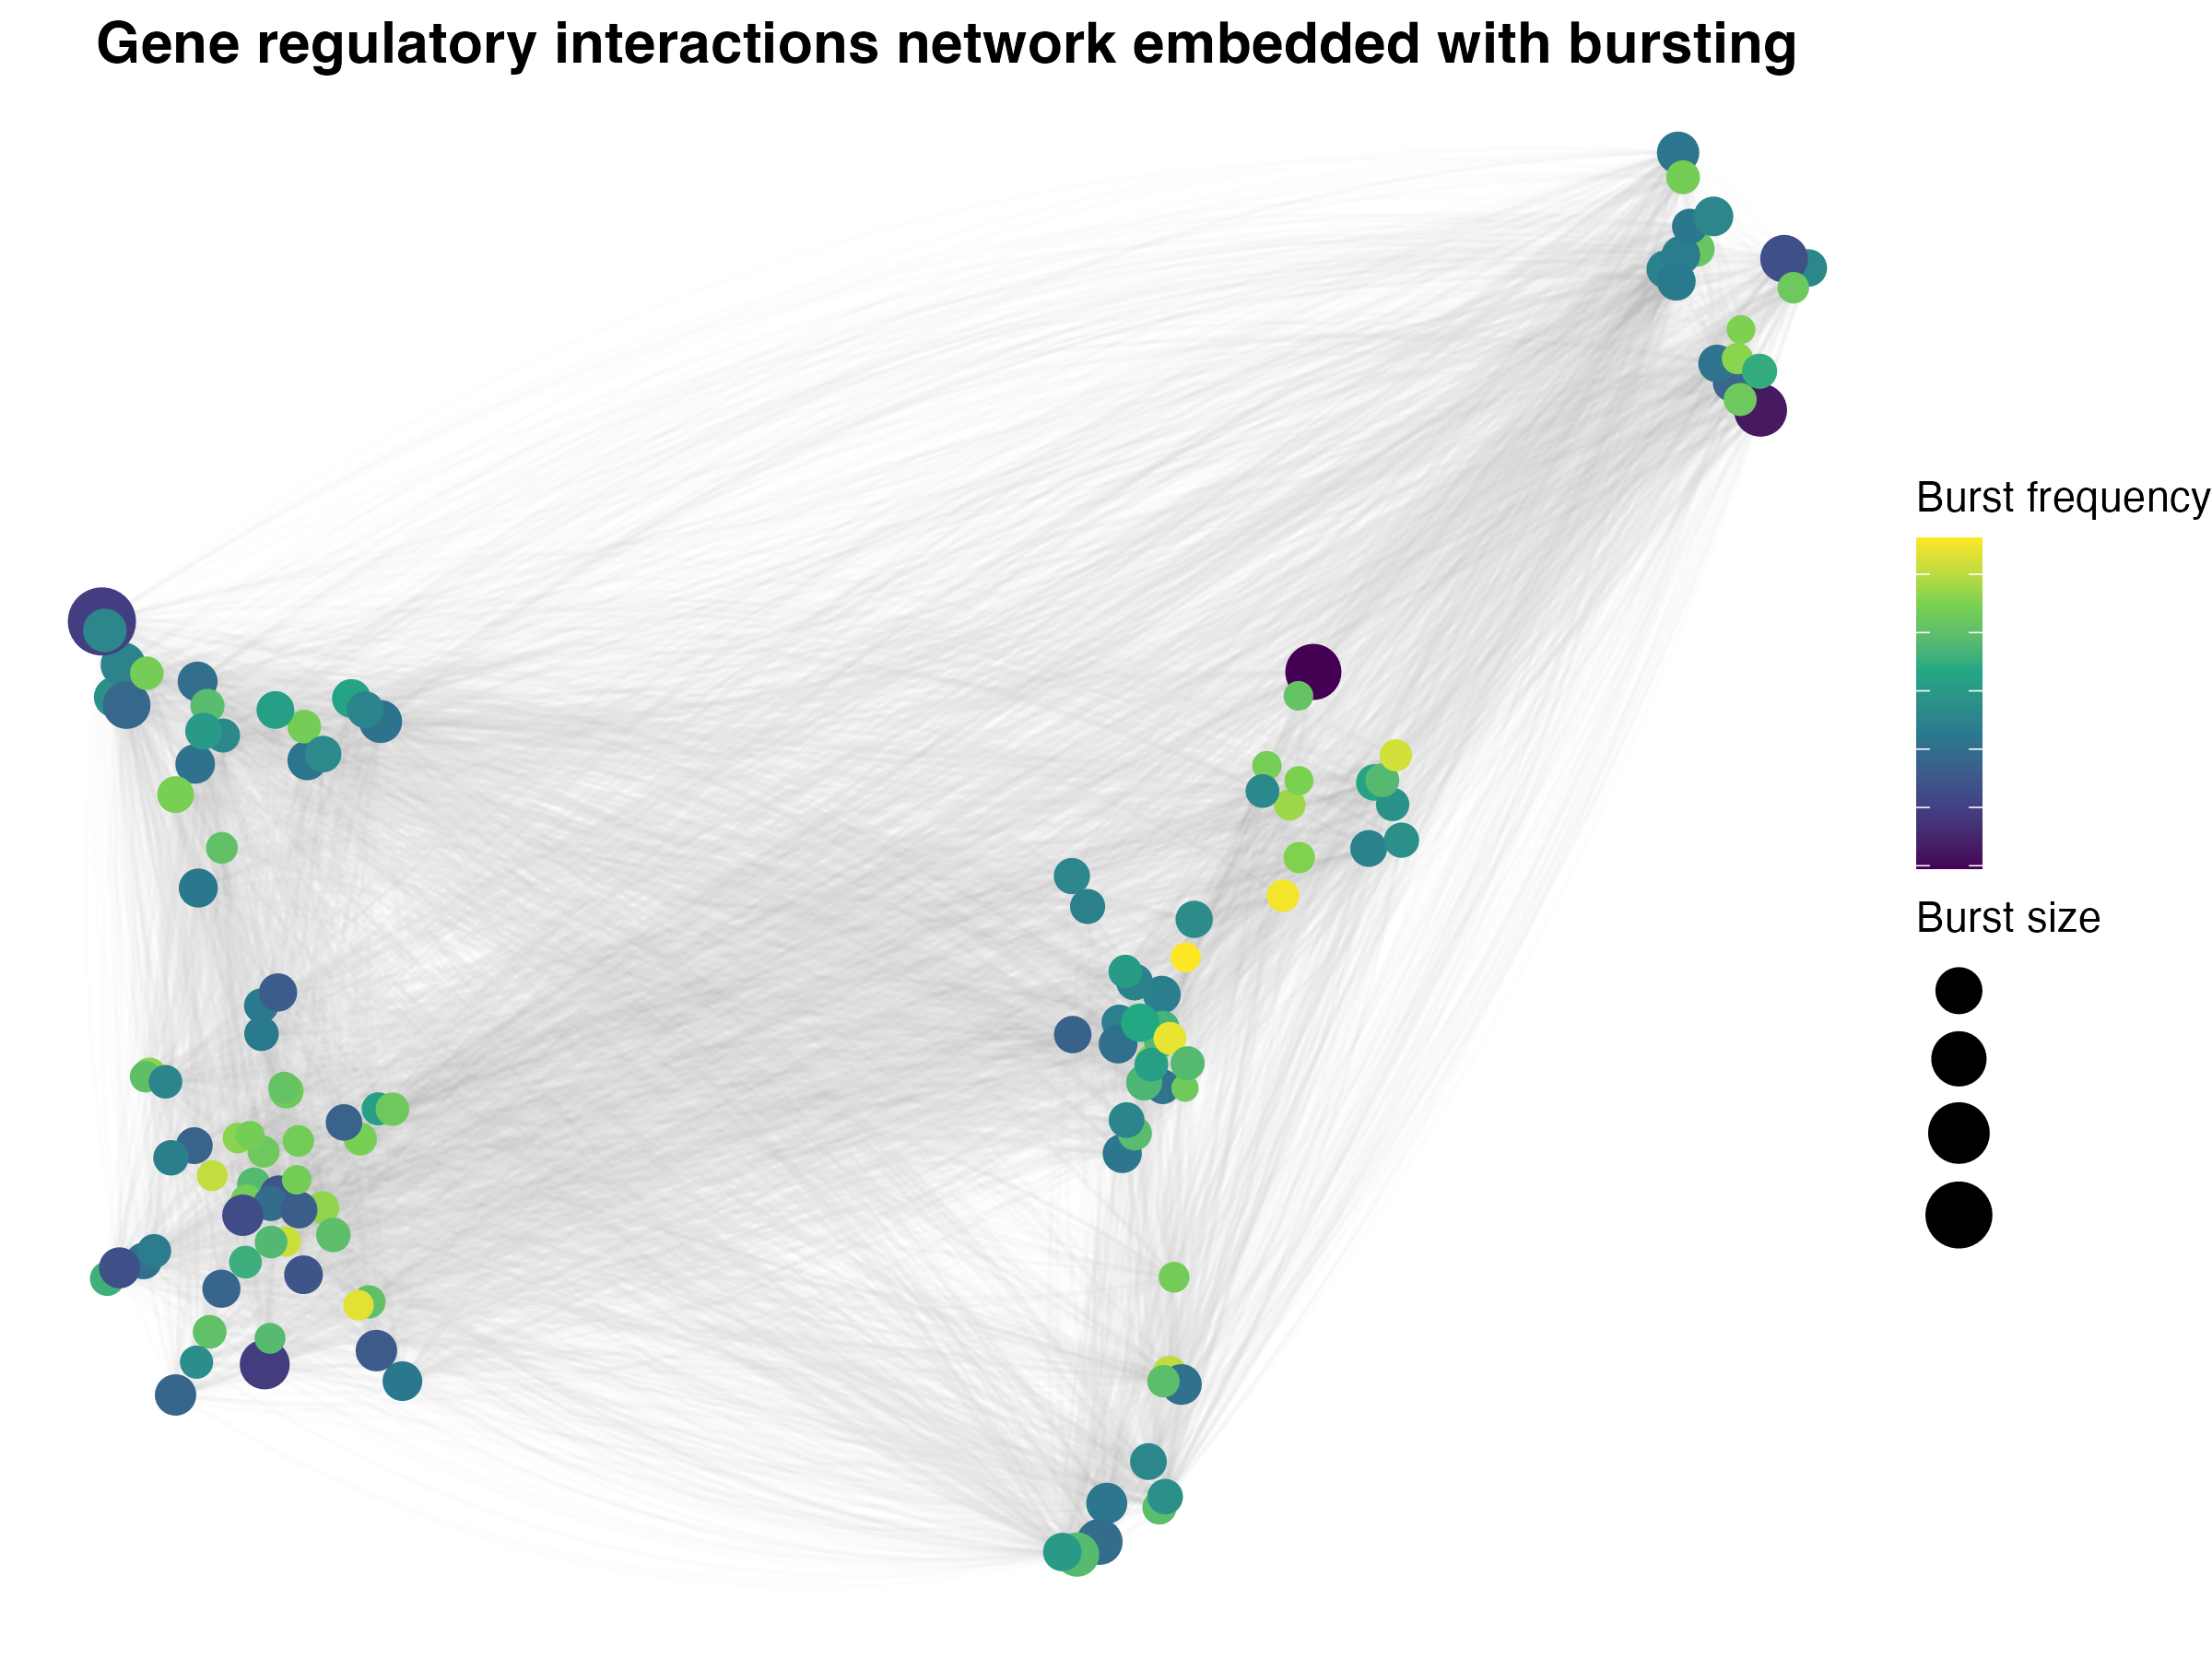

In [3]:
display(Image(filename=os.path.abspath("primary_mouse_data/inference_results/network_plot.png"), width=600))

## Downstream analysis

Based on our previously obtained inferences, we perform a series of downstream analyses and visualizations.

### Identify gene roles (TF, TG)

 We identify the gene roles, transcriptional factor genes (TFs) and target genes (TGs), based on the inferred gene regulatory interactions network. 

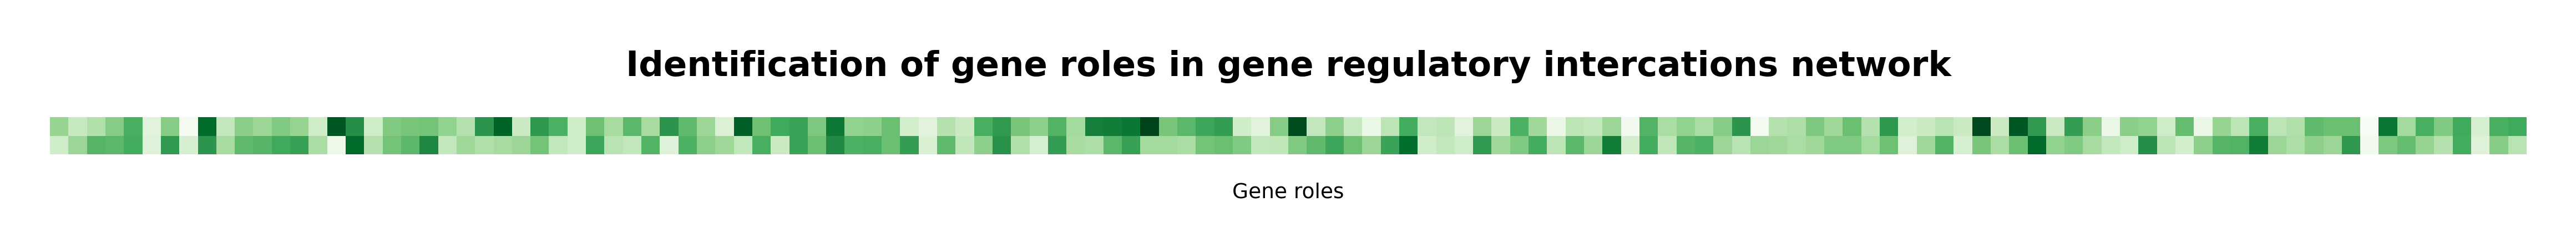

In [5]:
degree_result_ = pd.read_csv(os.path.abspath('primary_mouse_data/inference_results/degree_data.csv'))
bl._utils._plotting.gene_roles_heatmap(np.matrix(degree_result_))

### Busrting manners among differenct gene regulatory loops

In [6]:
inference_result = os.path.abspath('primary_mouse_data/inference_results/feedback_infer_results.csv')

First, we visualize the inferred bursting information, and divide the genes into two groups based on average expression levels (high expression group, low expression group) to ensure unbiased comparison at the same level.

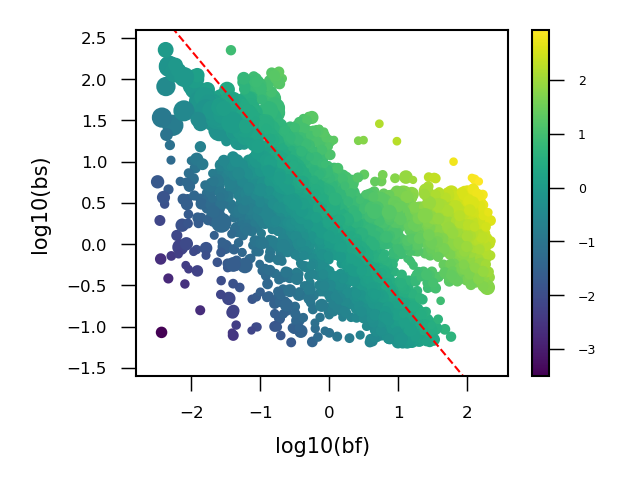

In [7]:
bl.plotting.scatterplot_burst(inference_result, [-2.5, 3.0, -1.2, 2.5], True, [-2.8, 2.6], [-1.6, 2.6])

Next, we predict expression variability and burst kinetics under different regulatory loop types for two groups (high expression group, low expression group) respectively.

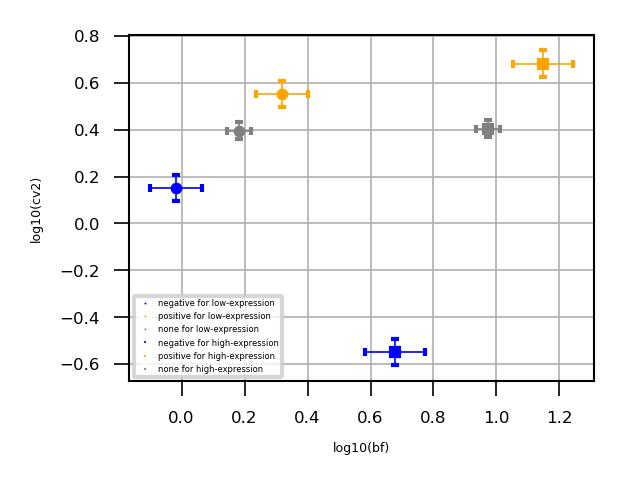

In [8]:
bl.tools._downstream_analysis.interaction_burst_regression(inference_result)

We compare expression variability and burst kinetics in different regulatory interactions types for two groups (high expression group, low expression group) respectively.

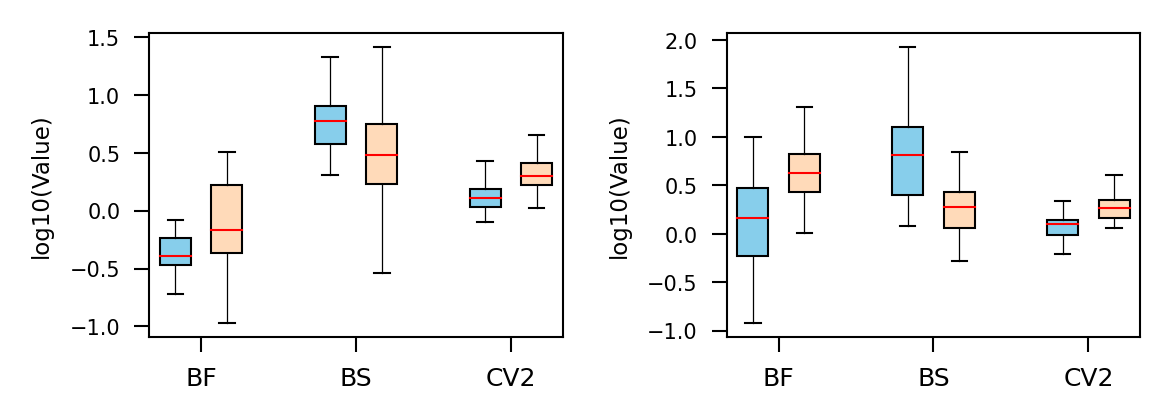

(array([0.00050619]),
 array([0.00179643]),
 array([3.42874289e-06]),
 array([7.94546738e-06]),
 array([9.14997013e-07]),
 array([4.4035818e-06]))

In [3]:
burst_info_file = os.path.abspath('primary_mouse_data/inference_results/burst_info.csv')
bl.tools._downstream_analysis.burst_interaction_overall(burst_info_file)

### TF binding kinetics analysis

We investigate how the binding dynamics of TF influence transcriptional bursting on a genome-wide level via two perspectives: (1) the affinity between TFs and the binding sites measured by the equilibrium binding constant r;

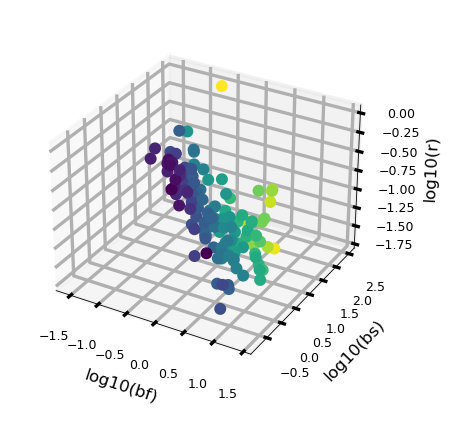

(-0.009351319118099614,
 0.2768448636779833,
 7.754443114606798e-44,
 1.2033083388647786e-82)

<Figure size 5760x4320 with 0 Axes>

<Figure size 5760x4320 with 0 Axes>

In [4]:
infer_result_filename = os.path.abspath('primary_mouse_data/inference_results/feedback_infer_results.csv')
burst_info = bl.tools._downstream_analysis.burst_info_summarize(infer_result_filename)
bl.tools._downstream_analysis.affinity_burst(burst_info)

(2) the number of binding sites measured by the regulated-interaction level, the incoming regulated signals for each gene in the inferred regulatory network. 

<Figure size 5760x4320 with 0 Axes>

<Figure size 5760x4320 with 0 Axes>

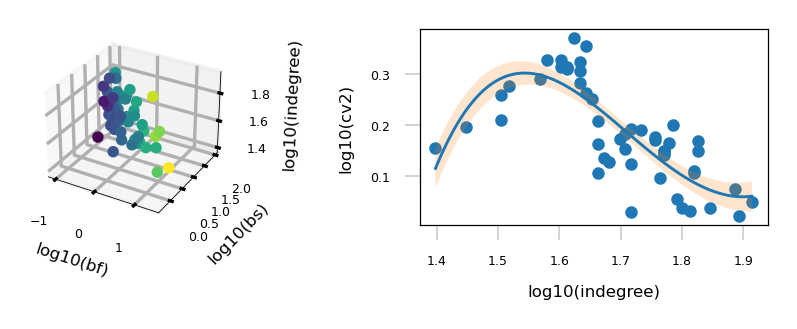

(-0.017964188949593347,
 0.012483734364251008,
 array([1.33245508e-37]),
 array([3.24730477e-31]),
 1.0109692807688143e-29,
 2.472408331368363e-75)

In [5]:
readfile_name = os.path.abspath('primary_mouse_data/inference_results/degree_data.csv')
bl.tools._downstream_analysis.burst_interactionlevel_positive(readfile_name, burst_info, os.path.abspath('primary_mouse_data/inference_results/sorted_indegree_cv2.csv'))